In this notebook, we will build a 2-layer Multi-Layer Perceptron (MLP) using the engine we played with in ``01_engine.ipynb``.

In [1]:
from karpathy_nn.micrograd.engine import Value
from karpathy_nn.micrograd.nn import MLP, Neuron
from karpathy_nn.micrograd.utils import draw_graph


Value(data=-0.3045764614437662, grad=0)


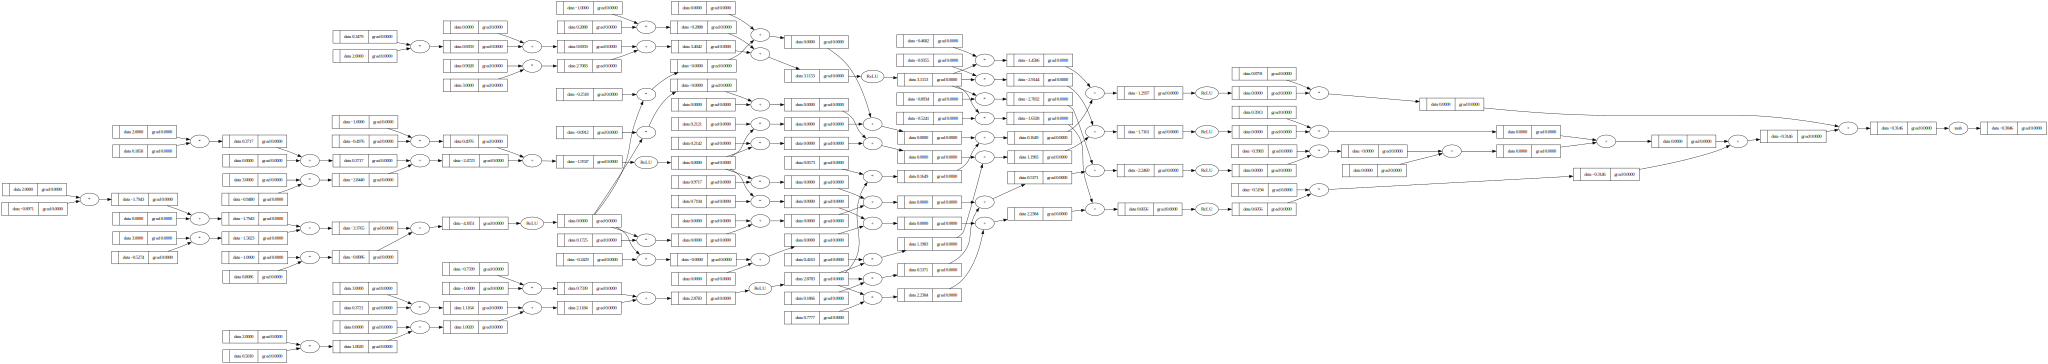

In [2]:
x = [2.0, 3.0, -1.0]
# 2 hidden layers + 1 output layer
model = MLP(
    num_input_neurons=3, num_output_neurons_per_layer=[4, 4, 1], final_act="Tanh"
)

print(model(x))
draw_graph(model(x))


Let's now define a toy dataset to train our model on.

In [3]:
# Inputs:
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]

# Targets:
ys = [1.0, -1.0, -1.0, 1.0]
ypreds = [model(x) for x in xs]
ypreds


[Value(data=-0.3045764614437662, grad=0),
 Value(data=-0.695208679477482, grad=0),
 Value(data=0.0, grad=0),
 Value(data=-0.37805599126397293, grad=0)]

We want a very simple binary classifier. The current weights are obviously bad. Let's train the network!

We define the loss first, which measures how well the neural network performs. To this end, we use the sum squared error (SSE) loss:
$$\text{SSE}(y, \hat{y}) = \sum_{i = 1}^n (y - \hat{y})^2.$$

If we used {0, 1} labels, we could also use the binary cross-entropy loss:
$$\text{BCE}(y, \hat{y}) = -\frac{1}{n} \sum_{i = 1}^n y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i).$$
The latter is the usual choice for training binary classifiers.

In [4]:
def BCE(ys: list[float], ypreds: list[Value]) -> Value:
    log_likelihood = 0
    for y, ypred in zip(ys, ypreds):
        curr_log_likelihood = y * ypred.log() + (1 - y) * (1 - ypred).log()
        log_likelihood += curr_log_likelihood

    log_likelihood = log_likelihood / len(ys)

    return -log_likelihood


def SSE(ys: list[float], ypreds: list[Value]) -> Value:
    loss = sum((ypred - y) ** 2 for y, ypred in zip(ys, ypreds))

    return loss


loss = SSE(ys, ypreds)
loss.backward()


When we hit enter in the last cell, something magical happened. The gradients of all the weights (and also the inputs, which are not that useful for us) were populated, which directly allows us to use a first-order optimization algorithm, such as gradient descent. Let's look at one of the weights of one of the neurons in the first layer:

In [5]:
model.layers[0].neurons[0].w[0]


Value(data=-0.8971262466351158, grad=0.0)

We can also visualize the computational graph corresponding to the loss, which is going to be massive:

In [6]:
# draw_graph(loss)


Note that we performed four forward passes through the network, each of which is reflected in the computational graph (notice the four arrows going out from each weight). The gradients backpropagate through this exact graph when we compute the gradients. It might seem efortless to write ``.backward()`` in PyTorch, but many-many things happen under the hood.

Let's see how many parameters this network has:

In [7]:
len(model.parameters())


41

Finally, let's write an optimization algorithm for the network.

In [8]:
def train(model: MLP, num_epochs: int = 100, learning_rate: float = 0.05) -> None:
    for epoch in range(num_epochs):
        ypreds = [model(x) for x in xs]
        loss = SSE(ys, ypreds)

        # This is usually crucial to not let gradients accumulate infinitely.
        # However, interestingly, accumulation seems to help us in this case.
        # The only reason why it worked is that we have a very-very easy
        # dataset and the neural network can fit it very easily. If the gradients
        # accumulate, it simply gives us a very high step size and makes us converge
        # extremely fast. It also makes the training more unstable, though.
        # For larger datasets and more complex problems, this usually prohibits
        # successful optimization.
        model.zero_grad()
        loss.backward()
        print(f"Epoch {epoch}: loss = {loss.data:.9f}")

        for parameter in model.parameters():
            parameter.data -= learning_rate * parameter.grad


In [9]:
model = MLP(
    num_input_neurons=3, num_output_neurons_per_layer=[4, 4, 1], final_act="Tanh"
)
train(model)


Epoch 0: loss = 8.481456052
Epoch 1: loss = 7.249438731
Epoch 2: loss = 5.424877245
Epoch 3: loss = 3.433742292
Epoch 4: loss = 2.770901437
Epoch 5: loss = 2.811253699
Epoch 6: loss = 2.155076046
Epoch 7: loss = 1.751508598
Epoch 8: loss = 1.163056050
Epoch 9: loss = 0.911680953
Epoch 10: loss = 0.730865155
Epoch 11: loss = 0.575911977
Epoch 12: loss = 0.473204209
Epoch 13: loss = 0.409649806
Epoch 14: loss = 0.357814282
Epoch 15: loss = 0.309504061
Epoch 16: loss = 0.272377660
Epoch 17: loss = 0.245745020
Epoch 18: loss = 0.229177268
Epoch 19: loss = 0.206015915
Epoch 20: loss = 0.187244273
Epoch 21: loss = 0.171548670
Epoch 22: loss = 0.158179491
Epoch 23: loss = 0.146692284
Epoch 24: loss = 0.136639445
Epoch 25: loss = 0.129006259
Epoch 26: loss = 0.121867853
Epoch 27: loss = 0.114562694
Epoch 28: loss = 0.108056918
Epoch 29: loss = 0.102251282
Epoch 30: loss = 0.098431824
Epoch 31: loss = 0.094299771
Epoch 32: loss = 0.089658187
Epoch 33: loss = 0.085452991
Epoch 34: loss = 0.08162

The model trains nicely. We could change the intermediate activations to tanh or sigmoid as well. As discussed previously, we could even change the output activation to sigmoid, if we transformed our {-1, 1} labels into {0, 1} labels. The tanh output activation leads to a faster convergence than the sigmoid by default, but if we account for the smaller slope of the sigmoid around 0 (i.e., if we multiply the learning rate by 4 to match the slope of the tanh), we get very quick convergence just as well.

We can do a grad check for a single neuron as follows.

In [10]:
model = Neuron(num_input_neurons=3, nonlinearity="Sigmoid")

l1 = SSE(ys, [model(x) for x in xs])
print(l1)
model.b.data += 0.001
l2 = SSE(ys, [model(x) for x in xs])
print(l2)
print("approx. grad", (l2 - l1) / 0.001)
model.b.data -= 0.001

l = SSE(ys, [model(x) for x in xs])
l.backward()
print("grad", model.b.grad)


Value(data=6.287942266720788, grad=0)
Value(data=6.288804181668731, grad=0)
approx. grad Value(data=0.8619149479427435, grad=0)
grad 0.8619890703763128


Not so surprisingly (because the model trained well), the model passes the grad check.